In [1]:
import pandas as pd
import h5py
import numpy as np

import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score

import shap
import pickle

from math import isclose

/home/mlindner/.conda/envs/netsci_jupyter/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [2]:
work_dir = "/home/mlindner/coen/micha/netsci_vs_gnn/"

X20_path = work_dir + "grids20/network_measures_final.csv"
y20_path = work_dir + "grids20/snbs_complete.h5"
X100_path = work_dir + "grids100/network_measures_final.csv"
y100_path = work_dir + "grids100/snbs_complete.h5"
Xtex_path = work_dir + "gridstexas/network_measures_final.csv"
ytex_path = work_dir + "gridstexas/snbs_1.h5"



with h5py.File(y20_path, 'r') as hf:
    y20 = np.array(hf.get(list(hf.keys())[0])).flatten()

with h5py.File(y100_path, 'r') as hf:
    y100 = np.array(hf.get(list(hf.keys())[0])).flatten()

with h5py.File(ytex_path, 'r') as hf:
    ytex = np.array(hf.get(list(hf.keys())[0])).flatten()


In [3]:
# This is from the model reported in the paper    
    
X20 = pd.read_csv(X20_path).drop(columns=["node_cat", "proper leaf"])
X100 = pd.read_csv(X100_path).drop(columns=["node_cat", "proper leaf"])
Xtex = pd.read_csv(Xtex_path).drop(columns=["node_cat", "proper leaf"])

In [4]:
names = ['P', 'AP', 'A²P', 'A³P', 'row-sum A²', 'row-sum A³', 'node degree',
       'degree centrality', 'minimum neighbor degree', 'maximum neighbor degree',
       'clustering coefficient', 'betweenness centrality', 'closeness centrality',
       'load centrality', 'eigenvector centrality', 'Katz centrality',
       'second-order centrality', 'current-flow closeness centrality',
       'current-flow betweenness centrality', 'mean neighbor degree',
       'harmonic centrality', 'square clustering', 'eccentricity',
       'bulk', 'root', 'dense sprout', 'sparse sprout', 'inner tree node',
       'fiedler vector', 'node connected to max loaded line',
       'max load connected lines', 'min load connected lines',
       'mean load connected lines', 'resistance-distance centrality',
       'degree assortativity coefficient', 'transitivity', 'diameter',
       'P-assortativity coefficient ', 'Kirchhoff index',
       'resistance-distance Kirchhoff index', 'inverse algebraic connectivity',
       'eigenratio', 'power sign ratio', 'max line load',
       'universal Kuramoto order parameter', 'graph connected w/o max loaded line',
       'max line load DC w/o max loaded line', 'backup capacity']

In [5]:
X20.columns = names
X100.columns = names
Xtex.columns = names

# Train test split

In [8]:
## Split test sets

assert isclose(len(X20) * 0.85 % 1, 0, abs_tol=10e-12)

X20_test = X20.iloc[int(len(X20) * 0.85):]
y20_test = y20[int(len(y20) * 0.85):]

assert isclose(len(X100) * 0.85 % 1, 0, abs_tol=10e-12)

X100_test = X100.iloc[int(len(X100) * 0.85):]
y100_test = y100[int(len(y100) * 0.85):]





In [9]:
model = make_pipeline(VarianceThreshold(), StandardScaler(), 
                      HistGradientBoostingRegressor(
                          max_iter=1750, n_iter_no_change=100, random_state=1,
                          loss="poisson",  learning_rate=0.09, early_stopping=False))


In [10]:
for X, y, nodes_per_grid in [(X20, y20, 20), (X100, y100, 100)]:
    train_fraction = 0.7
    assert isclose(len(X) * train_fraction % 1, 0, abs_tol=10e-12)
    X_train = X.iloc[:int(len(X) * train_fraction)]
    y_train = y[:int(len(y) * train_fraction)]
    X_test = X.iloc[int(len(X) * 0.85):]
    y_test = y[int(len(y) * 0.85):]
    
    model.fit(X_train, y_train)
    train_r2 = r2_score(y_train, model.predict(X_train))
    ev20 = r2_score(y20_test, model.predict(X20_test))
    ev100 = r2_score(y100_test, model.predict(X100_test))
    evTex = r2_score(ytex, model.predict(Xtex))

    print("Train R2:", train_r2)
    print("Did not apply the right scaling for out of sample prediciton!")
    print("ev20 R2:", ev20)
    print("ev100 R2:", ev100)
    print("evTex R2:", evTex)
    
    explainer = shap.TreeExplainer(model[2])
    Xtest = pd.DataFrame(model[0:2].transform(X_test), columns=X.columns)
    shapX = explainer(Xtest)
    
    with open(f"shapX{nodes_per_grid}.pkl","wb") as f:
        pickle.dump(shapX, f)
    
    try:
        shap.summary_plot(shapX, max_display=12, show=False)
        plt.savefig(f"shap_HistGBR{nodes_per_grid}.png", dpi=400)
    except:
        print("Error during printing!")

Train R2: 0.907867292865949
Did not apply the right scaling for out of sample prediciton!
ev20 R2: 0.819979106765377
ev100 R2: -0.31363946794419983
evTex R2: -2.710503819778035
Error during printing!
Train R2: 0.8739932001750793
Did not apply the right scaling for out of sample prediciton!
ev20 R2: 0.3030970889754525
ev100 R2: 0.8419306048177068
evTex R2: -0.49265462423580764
Error during printing!


# Now for Plotting

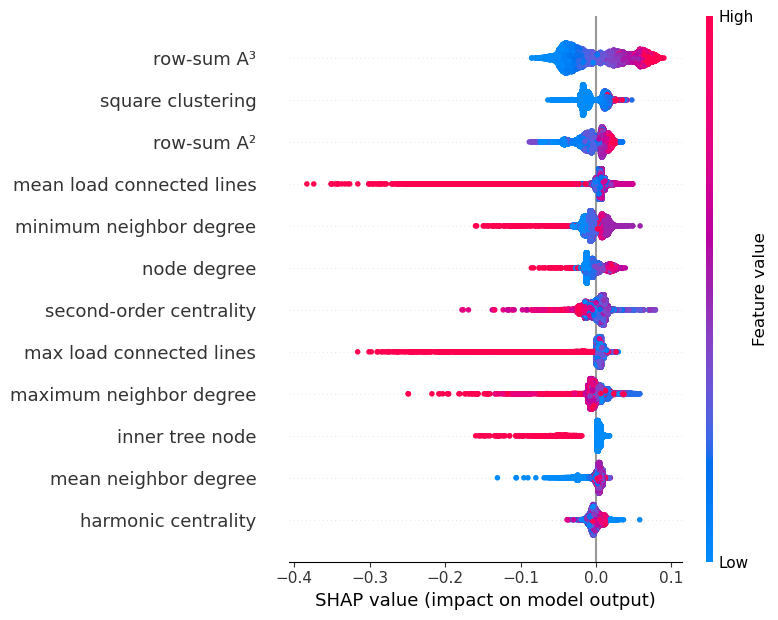

In [14]:
with open("shapX20.pkl","rb") as f:
    shapX20 = pickle.load(f)
shap.summary_plot(shapX20, max_display=12, show=False)
plt.savefig(f"shap_HistGBR20.png", dpi=400)

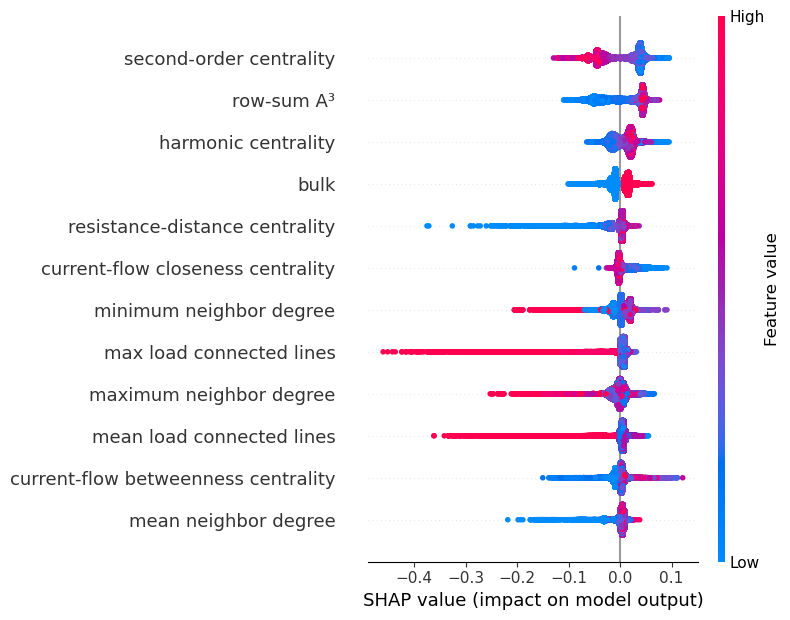

In [15]:
with open("shapX100.pkl","rb") as f:
    shapX100 = pickle.load(f)
shap.summary_plot(shapX100, max_display=12, show=False)
plt.savefig(f"shap_HistGBR100.png", dpi=400)

# Old tries


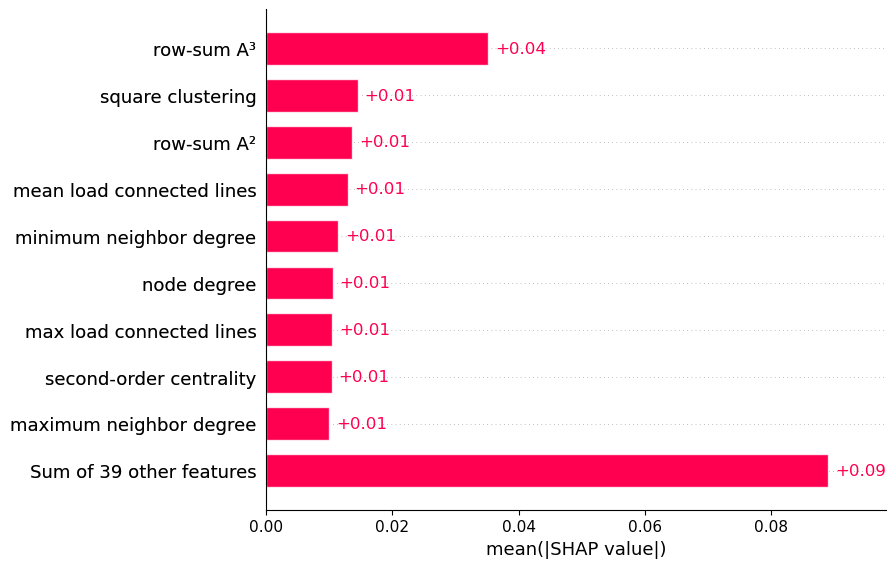

In [23]:
shap.plots.bar(shapX)

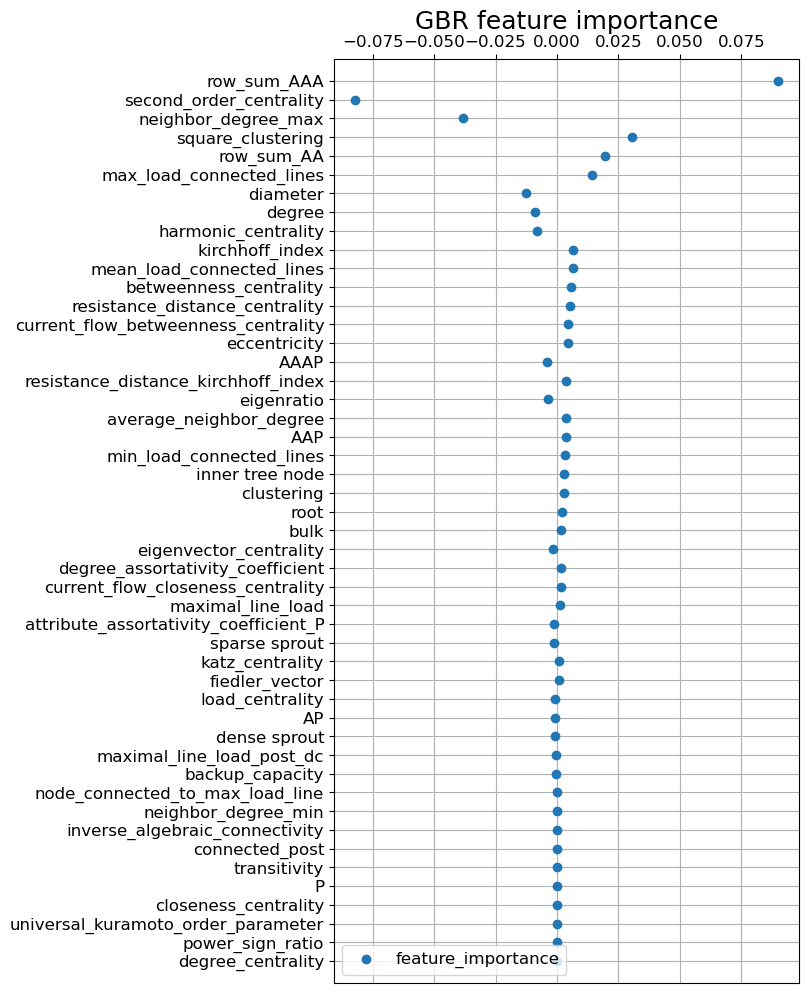

In [109]:
fig = plt.figure(figsize=(6,12))

#plt.scatter(*reversed(list(zip(*sorted(zip(X100.columns, r_regression(X100,y100)), key=lambda x: x[1])))), color="tab:red", marker="x", zorder=2)
plt.scatter(*reversed(list(zip(*sorted(zip(X20.columns, shapX.values.mean(axis=0)), key=lambda x: np.abs(x[1]))))), color="tab:blue", marker="o")
#plt.scatter(*reversed(list(zip(*sorted(zip(X20.columns, perm_imp["importances_mean"]), key=lambda x: x[1])))), color="tab:orange", marker="*")

#plt.scatter(*reversed(list(zip(*sorted(zip(X100.columns, r_regression(Xtex,ytex)), key=lambda x: x[1])))), color="tab:orange", marker="*")
#plt.tight_layout()


ax = plt.gca()
ax.xaxis.tick_top() 
ax.xaxis.set_label_position('top') 
ax.set_axisbelow(True)

plt.margins(0.05, 0.025)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("GBR feature importance", fontsize=18)
plt.grid()
plt.legend(["feature_importance","permutation_importance"], fontsize=12, loc="lower left")
#plt.savefig("univariate_r2.png", dpi=400, bbox_inches='tight')
plt.show()

In [107]:
plt.legend?

# Plot feature importances

In [28]:
from sklearn.inspection import permutation_importance

perm_imp= permutation_importance(model,X20_test,y20_test)

In [30]:
perm_imp["importances_mean"]

array([0.00034728, 0.00378079, 0.00091373, 0.00096924, 0.08211115,
       0.2743229 , 0.07572501, 0.        , 0.05955137, 0.13429902,
       0.03691049, 0.02486333, 0.00832517, 0.01040443, 0.01067491,
       0.00778449, 0.14954435, 0.01119068, 0.0287205 , 0.02697461,
       0.05703053, 0.02490542, 0.0010907 , 0.01443991, 0.00353252,
       0.00075906, 0.01312453, 0.02897422, 0.0012642 , 0.01082298,
       0.0015463 , 0.08648136, 0.01023032, 0.08863075, 0.01157474,
       0.00114967, 0.0030051 , 0.00194346, 0.00030087, 0.00749766,
       0.00186633, 0.01694887, 0.00820825, 0.00047087, 0.03150944,
       0.00283525, 0.01185197])

In [11]:
fig = plt.figure(figsize=(6,12))

#plt.scatter(*reversed(list(zip(*sorted(zip(X100.columns, r_regression(X100,y100)), key=lambda x: x[1])))), color="tab:red", marker="x", zorder=2)
plt.scatter(*reversed(list(zip(*sorted(zip(X20.columns, model[-1].feature_importances_), key=lambda x: x[1])))), color="tab:blue", marker="o")
#plt.scatter(*reversed(list(zip(*sorted(zip(X20.columns, perm_imp["importances_mean"]), key=lambda x: x[1])))), color="tab:orange", marker="*")

#plt.scatter(*reversed(list(zip(*sorted(zip(X100.columns, r_regression(Xtex,ytex)), key=lambda x: x[1])))), color="tab:orange", marker="*")
#plt.tight_layout()


ax = plt.gca()
ax.xaxis.tick_top() 
ax.xaxis.set_label_position('top') 
ax.set_axisbelow(True)

plt.margins(0.05, 0.025)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("GBR feature importance", fontsize=18)
plt.grid()
plt.legend(["feature_importance","permutation_importance"], fontsize=12)
#plt.savefig("univariate_r2.png", dpi=400, bbox_inches='tight')
plt.show()

AttributeError: 'HistGradientBoostingRegressor' object has no attribute 'feature_importances_'

<Figure size 600x1200 with 0 Axes>